_Load Packages:_

In [1]:
import pandas as pd
import numpy as np
import GEOparse
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

_Project Overview:_

The aim of this project is to build and evaluate a mathematical model that can discriminate between two lung cancer subtypes. To build this model I use an unsupervised k-means clustering algorithm (Euclidean distance) of 58 Non-Small Cell Lung Cancer (NSCLC) tumors using k=2. 

To evaluate the model I compute the model accuracy, which in this case is the percentage of samples that the model assigns to the wrong subtype out of all the samples it classifies. 

After evaluating the performance of the model, I further examine a specific biological application for identifying gene-specific expression value differences between AD and SCC samples, and validate these findings using previous literature to support its potential use in biomaarker discovery. 

The data (available in the SOFT formatted family file from GEO Accession here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE10245) contains 40 adenocarcinoma (AD) samples and 18 squamous cell carcinoma (SCC) samples.

------------------------------------------------------------------------------------------------------------------------------

__1): Load in Data:__

In the function below we load, organize, and manipulate our GSE data into a dataframe that, for each GSM sample, contains expression values for each respective gene. Additionally, I identify the corresponding cancer type (AD or SCC) for each sample ID.

In [3]:
#load in sample data and metadata
gse_file = GEOparse.get_GEO(filepath="./GSE10245_family.soft.gz")
metadata = gse_file.phenotype_data;

10-Jun-2024 20:50:44 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
10-Jun-2024 20:50:44 DEBUG GEOparse - DATABASE: GeoMiame
10-Jun-2024 20:50:44 DEBUG GEOparse - SERIES: GSE10245
10-Jun-2024 20:50:44 DEBUG GEOparse - PLATFORM: GPL570
/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258551
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258552
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258553
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258554
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258555
10-Jun-2024 20:50:46 DEBUG GEOparse - SAMPLE: GSM258556
10-Jun-2024 20:50:47 DEBUG GEOparse - SAMPLE: GSM258557
10-Jun-2024 20:50:47 DEBUG GEOparse - SAMPLE: GSM258558
10-Jun-2024 20:50:47 DEBUG GEOparse - SAMPLE: GSM258559
10-Jun-2024 

In [5]:
def load_GSE(gse_file, metadata):
    
    """
    Function for matching gene expression values for each respective GSM sample loaded from raw GSE data and metadata

    Args:
        gse_file (series): filepath of zipped GSE file to be analyzed
        metadata (dataframe): dataframe of misc. metadata associated with each GSM sample contained in gse_file

    Returns:
        gene_expression_df (dataframe): dataframe of each GSM sample within the GSE file and its respective expression value per gene
        cancer_type_df (dataframe): dataframe of each GSM sample and its corresponding cancer subtype
    """
    
    #ignore output of warnings from reading in GSE data and df manipulation
    with warnings.catch_warnings():
        
        #suppress output of warnings/error pertaining to df manipulation or future package deprecation
        warnings.simplefilter("ignore", FutureWarning)
        warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning) 
        
        #create empty dataframe with range of total gene IDs and column headers
        col_id = gse_file.gsms['GSM258562'].table["ID_REF"]
        gene_expression_df = pd.DataFrame(index=range(0),columns=range(len(col_id)))
        gene_expression_df.columns = col_id
        
        #combine gene expression values from each GSM sample to a single dataframe
        for sample in gse_file.gsms.keys():
            gse_table = gse_file.gsms[sample].table
            gse_pivot_table = gse_table.pivot_table(columns = "ID_REF", values = "VALUE")
            gene_expression_df = pd.concat([gene_expression_df, gse_pivot_table])
        
        #add GSM sample ID as row header
        gene_expression_df.index = gse_file.gsms.keys()
        
        #create supplementary df containing cancer subtype corresponding to each sample ID
        phenotypes = metadata.iloc[:,[0,1]]
        phenotypes["Type"] = ['Adenocarcinoma' if "AC" in x else 'Squamous Cell Carcinoma' for x in phenotypes['title']]
        cancer_type_df = pd.DataFrame(data = phenotypes.iloc[:,[1,2]])
        cancer_type_df = cancer_type_df.reset_index().drop(columns = "geo_accession").rename(columns = {"index":"sample"})
                    
    return gene_expression_df, cancer_type_df

In [10]:
gene_expression_df, cancer_type_df = load_GSE(gse_file, metadata)
gene_expression_df

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
GSM258551,9.129905,8.034022,3.564520,4.746490,2.320698,5.519153,3.339182,2.775395,8.303437,2.981327,...,10.297589,8.857847,9.369037,9.435077,10.936404,10.730983,13.599488,13.031726,15.028729,14.586347
GSM258552,9.843349,7.973332,4.994852,5.197306,2.248520,5.081258,2.934516,2.617097,9.145519,4.619668,...,8.217455,7.865127,8.116953,8.306683,9.986505,9.719266,12.847711,12.250033,14.440756,14.072366
GSM258553,9.730661,8.834045,5.066018,5.234618,2.259504,4.657257,3.007192,2.634559,9.159054,2.746464,...,8.713199,6.996104,7.803869,8.029131,9.468096,9.101115,12.384142,11.798363,14.439887,14.011392
GSM258554,9.032165,7.723965,4.958580,6.078180,2.262787,4.535683,3.167112,3.127495,7.770354,6.212399,...,8.805233,8.221659,8.434090,8.609512,10.064087,9.763076,12.969199,12.307684,14.557363,14.162145
GSM258555,10.281793,9.040800,4.951835,5.205632,2.207531,3.731919,2.711790,2.707079,6.380928,4.528499,...,8.285092,8.042156,8.174685,8.620098,10.005558,9.651785,12.924465,12.243207,14.612223,14.122751
GSM258556,9.154551,8.792375,6.428274,5.009848,2.322618,4.964672,2.958602,2.598406,8.149710,4.008140,...,8.903710,8.088932,8.438776,8.687646,10.212622,9.716659,12.996885,12.369919,14.593751,14.202961
GSM258557,8.063788,8.093354,7.364676,5.533000,2.656929,5.794959,2.984828,2.634927,9.420926,4.039786,...,8.431760,8.395615,8.895953,9.058438,10.523917,10.224866,13.180944,12.688711,14.697993,14.339175
GSM258558,8.881805,7.575620,4.659326,5.362637,2.255955,5.416322,3.075674,2.637682,9.460713,2.797617,...,8.941418,8.205632,8.598923,8.832244,10.313588,9.968033,13.074864,12.541047,14.626500,14.292254
GSM258559,9.039005,8.438594,6.643723,5.210988,2.266399,5.627705,2.975612,2.663941,7.842213,2.748887,...,8.518448,8.189411,8.400951,8.484782,9.954478,9.698518,12.782987,12.103870,14.546733,14.058803
GSM258560,10.643545,9.142260,5.368356,5.195820,2.246563,4.174514,2.968054,2.609029,7.356981,2.722873,...,8.951526,8.004727,8.110386,8.529225,9.872159,9.457238,12.767953,12.280146,14.523177,14.159513


------------------------------------------------------------------------------------------------------------------------------

__2): Clustering:__

In the function below I perform clustering on the 58 GSM samples in the dataset using scikit-learns kmeans clustering.

In [7]:
def assign_cluster(k):
    
    """
    Function for assigning cluster value to each GSM sample

    Args:
        k (int): # of clusters to be assigned (two by default)

    Returns:
        cluster_sample_df (dataframe): dataframe containing GSM sample, corresponding cancer subtype, and custer value assigned by scikit kmeans clustering
        cluster_val_df (dataframe): dataframe containing GSM sample and the assigned clustering value from scikit kmeans clustering
    """
    
    #assign gene expression df and cancer subtype df from load_GSE function
    gene_expression_df, cancer_type_df = load_GSE(gse_file, metadata)
    
    #assign random cluster (k = 2) to each GSM sample
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(gene_expression_df)
    labels_prediction = kmeans.predict(gene_expression_df)
    
    #create dataframe that contains GSM sample ID and cluster value (0 or 1)
    cluster_val_df = pd.DataFrame(gse_file.gsms.keys(), columns = ["sample"])
    cluster_val_df['cluster'] = labels_prediction.tolist()
    
    #merge dfs to produce new df with GMS sample ID, cancer subtype, and cluster value
    cluster_sample_df = cancer_type_df.merge(cluster_val_df, left_on = "sample", right_on = "sample")
    cluster_sample_df = cluster_sample_df.loc[:,["sample", "Type", "cluster"]]
            
    return cluster_sample_df, cluster_val_df

In [14]:
cluster_sample_df, cluster_val_df = assign_cluster(2)
cluster_sample_df

,sample,Type,cluster
0,GSM258551,Adenocarcinoma,1
1,GSM258552,Adenocarcinoma,1
2,GSM258553,Squamous Cell Carcinoma,1
3,GSM258554,Adenocarcinoma,1
4,GSM258555,Squamous Cell Carcinoma,1
5,GSM258556,Squamous Cell Carcinoma,0
6,GSM258557,Squamous Cell Carcinoma,1
7,GSM258558,Adenocarcinoma,1
8,GSM258559,Adenocarcinoma,1
9,GSM258560,Adenocarcinoma,1


------------------------------------------------------------------------------------------------------------------------------

__3): Computing Cluster Accuracy:__

In this section, I compute the accuracy score of kmeans clustering by manually calculating the clustering accuracy by performing the following:

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

I then validate the output of my manually calculated clustering accuracy (method == "manual") by cross-checking the output with scikit-learns built-in accuracy_score function (method == "scikit") to ensure there are no computational differences between methods.

In [9]:
def compute_cluster_acc(method):
    
    """
    Function for manually computing accuracy score of kmeans clustering for cancer subtypes of each GSM sample

    Args:
         method (string): "manual" for manual calculation or "scikit" for scikit's accuracy_score calculation of clustering accuracy

    Returns:
        cluster_acc (float): value as percentage representing clustering accuracy using respectve calculation method
    """
    
    #assign cluster_df and # of clusters from assign_cluster function
    cluster_df, cluster_val_df = assign_cluster(2)
    
    if method == "manual":
        
        #calculate false negatives for adenocarcinoma subtype
        AD_df = cluster_df[cluster_df.Type == "Adenocarcinoma"]
        AD_FN = len(AD_df[AD_df.cluster != 1])

        #calculate false negatives for squamous cell carcinoma subtype
        SCC_df = cluster_df[cluster_df.Type == "Squamous Cell Carcinoma"]
        SCC_FN = len(SCC_df[SCC_df.cluster == 1])

        #calculate total false negative count
        total_FN = int(AD_FN + SCC_FN)

        #calculate accuracy score %
        cluster_acc = (int(len(cluster_df) - total_FN) / (len(cluster_df)) * 100)
    
    elif method == "scikit":
        
        #assigning cluster val to respective cancer subtype
        cluster_df['cluster'] = cluster_df['Type'].apply(lambda x: 1 if "Adenocarcinoma" in x else 0 if "Squamous Cell Carcinoma" in x else -1)

        #merging dataframes to compare actual cluster of cancer type (correct cluster) to predicted cluster group (predicted cluster)
        cluster_comparison = cluster_val_df.merge(cluster_df, left_on = "sample", right_on = "sample")
        cluster_comparison = cluster_comparison.rename(columns = {"cluster_x":"predicted cluster", "cluster_y":"correct cluster"})

        #compute accuracy score using accuracy_score() function from scikit-learn
        cluster_acc = float(accuracy_score(cluster_comparison["predicted cluster"], cluster_comparison["correct cluster"]))*100
        
    return cluster_acc

In [11]:
cluster_acc = compute_cluster_acc("manual")
print("Manually computed clustering accuracy (%) =", round(cluster_acc, 2))

Manually computed clustering accuracy (%) = 67.24


In [13]:
cluster_acc = compute_cluster_acc("scikit")
print("scikit computed clustering accuracy (%) =", round(cluster_acc, 2))

scikit computed clustering accuracy (%) = 67.24


Running both manual and scikit's accuracy computations confirm that there is no computational difference between calculating accuracy score manually vs using scikit-learn's built-in package. Either can be used for future analysis, but I will be using the manual calculation.

------------------------------------------------------------------------------------------------------------------------------

__4): Computing Cluster Accuracy from 50/50 Training Data/Testing Data Split:__

in section 3): Computing Cluster Accuracy:, clustering was performed given that all 58 samples from the provided GSE file serve as "training data". However, I also want to identify discrepancies in computing cluster accuracy when "training" data is split in half and comparing the cluster accuracy for the other half of the data, or the "test" data.

In the functions below I split the data into halves - 20 AD and 9 SCC samples - to serve as the "training" data, and repeat cluster predictions on the remaining 29 samples (the "test" data) and compute cluster accuracy. 

After performing the above, the split for testing and training data will be flipped, and the resulting accuracy score will be compared.

In [38]:
def split_data():
    
    """
    Function for splitting GSM samples in half by cancer subtype 

    Args:
         None

    Returns:
        AD_df (dataframe): dataframe containing each sample corresponding to adenocarcinoma; primarily used for downstream analysis
        SCC_df (dataframe): dataframe containing each sample corresponding to squamous cell carcinoma; primarily used for downstream analysis
        gene_expression_df (dataframe): dataframe containing all gene expression data for all 58 samples
        data_1st_half (dataframe): dataframe containing split of 20 AD and 9 SCC sample IDs
        data_2nd_half (dataframe): dataframe containing remaining split of 20 AD and 9 SCC sample IDs
        expression_data_1st_half (dataframe): dataframe containing split of sample IDs and corresponding expression data
        expression_data_2nd_half (dataframe): dataframe containing split of sample IDs and corresponding expression data
    """
    
    gene_expression_df, cancer_type_df = load_GSE(gse_file, metadata)

    #creating training set and test set by splitting dataframe containing all AD cancer types
    AD_df = cancer_type_df[cancer_type_df["Type"] == "Adenocarcinoma"]
    AD_1st_half_data = AD_df.iloc[0:20, 0:2]
    AD_2nd_half_data = AD_df.iloc[20:40, 0:2]

    #creating training set and test set by splitting dataframe containing all SCC cancer types
    SCC_df = cancer_type_df[cancer_type_df["Type"] == "Squamous Cell Carcinoma"]
    SCC_1st_half_data = SCC_df.iloc[0:9, 0:2]
    SCC_2nd_half_data = SCC_df.iloc[9:18, 0:2]
    
    #merging training sets for AD and SCC (29 samples each)
    data_1st_half = AD_1st_half_data.merge(SCC_1st_half_data, how = "outer")
    data_2nd_half = AD_2nd_half_data.merge(SCC_2nd_half_data, how = "outer")
    
    #renaming gene identifier column and resetting index to prepare for merging (and for clarity of displayed data)
    gene_expression_df = gene_expression_df.reset_index()
    gene_expression_df.rename(columns={"index": "sample"}, inplace=True)
    
    #creating two dataframes, each with complete lists of 1st half and 2nd half of sample with respective expression data
    expression_data_1st_half = data_1st_half.merge(gene_expression_df, how = "inner")
    expression_data_1st_half = expression_data_1st_half.set_index("sample").drop(columns = "Type")

    expression_data_2nd_half = data_2nd_half.merge(gene_expression_df, how = "inner")
    expression_data_2nd_half = expression_data_2nd_half.set_index("sample").drop(columns = "Type")
    
    return AD_df, SCC_df, gene_expression_df, data_1st_half, data_2nd_half, expression_data_1st_half, expression_data_2nd_half

In [40]:
def compute_split_data(split, k):
    
    """
    Function for calculating clustering accuracy on testing data from predetermined training data 

    Args:
         split (str): determine how to split the data into training/testing: "1st half" or "2nd half"
         k (int): # of clusters to be assigned (two by default)

    Returns:
        cluster_acc (float): value as percentage representing clustering accuracy using respectve data split method
    """
    
    AD_df, SCC_df, gene_expression_df, data_1st_half, data_2nd_half, expression_data_1st_half, expression_data_2nd_half = split_data()
    
    if split == "1st half":

        #training model on 1st half of data and predicting 2nd half
        kmeans = KMeans(n_clusters = k, random_state=0)
        kmeans.fit(expression_data_1st_half) 
        labels_prediction = kmeans.predict(expression_data_2nd_half)
        
        #Resetting index for clearer dataframe formatting
        expression_data_1st_half = expression_data_1st_half.reset_index()
        expression_data_2nd_half = expression_data_2nd_half.reset_index()

        #predicting clusters
        cluster_data = pd.DataFrame(expression_data_2nd_half, columns = ["sample"])
        cluster_data['cluster'] = labels_prediction.tolist()
        
        #computing cluster accuracy
        cluster_data = data_2nd_half.merge(cluster_data, how = "inner")

    elif split == "2nd half":
        
        #training model on 1st half of data and predicting 2nd half
        kmeans = KMeans(n_clusters = k, random_state=0)
        kmeans.fit(expression_data_2nd_half) 
        labels_prediction = kmeans.predict(expression_data_1st_half)
        
        #Resetting index for clearer dataframe formatting
        expression_data_1st_half = expression_data_1st_half.reset_index()
        expression_data_2nd_half = expression_data_2nd_half.reset_index()

        #predicting clusters
        cluster_data = pd.DataFrame(expression_data_1st_half, columns = ["sample"])
        cluster_data['cluster'] = labels_prediction.tolist()
        
        #computing cluster accuracy
        cluster_data = data_1st_half.merge(cluster_data, how = "inner")
     
    #calculate false negatives for adenocarcinoma subtype
    AD_df = cluster_data[cluster_data.Type == "Adenocarcinoma"]
    AD_FN = len(AD_df[AD_df.cluster != 1])

    #calculate false negatives for squamous cell carcinoma subtype
    SCC_df = cluster_data[cluster_data.Type == "Squamous Cell Carcinoma"]
    SCC_FN = len(SCC_df[SCC_df.cluster == 1])

    #calculate total false negative count
    total_FN = int(AD_FN + SCC_FN)

    #calculate accuracy score %
    cluster_acc = (int(len(cluster_data) - total_FN) / (len(cluster_data)) * 100)

    return cluster_acc

In [31]:
cluster_acc = compute_split_data("1st half", 2)
print(f"Manually computed clustering accuracy (%) for 1st half as training data =", round(cluster_acc, 2))

Manually computed clustering accuracy (%) for 1st half as training data = 82.76


In [32]:
cluster_acc = compute_split_data("2nd half", 2)
print(f"Manually computed clustering accuracy (%) for 2nd half as training data =", round(cluster_acc, 2))

Manually computed clustering accuracy (%) for 2nd half as training data = 89.66


Both instances of splitting the data in half to serve as training data provides higher overall clustering accuracy at 82.76% and 89.66%. Compared to using all 58 samples as the training data, this only provided an accuracy score of 67.24% interestingly. These results may be indicative of model overfitting and reduces the models overall generalizability.  

------------------------------------------------------------------------------------------------------------------------------

__5): Graphical Analysis:__

Below I visualize the three computed accuracy scores of i) using all 58 samples as the training data, ii) training the model on the 1st half of the data and predicting the 2nd half, and iii) training the model on the 2nd half of the data and predicting the 1st half. Through plotting the data we can better identify the significant differences in accuracy score.

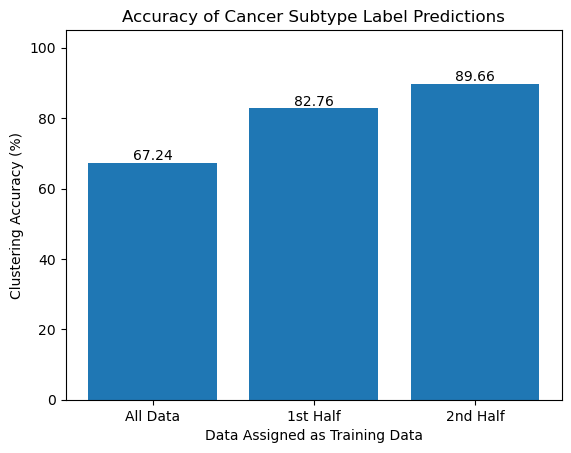

In [23]:
#Barplot of predicted clustering accuracy percentage
cluster_acc_all = compute_cluster_acc("manual")
cluster_acc_1 = compute_split_data("1st half", 2)
cluster_acc_2 = compute_split_data("2nd half", 2)

accuracy_list = [cluster_acc_all, cluster_acc_1, cluster_acc_2]
data_label = ["All Data", "1st Half", "2nd Half"]

fig, ax = plt.subplots()
bar_container = ax.bar(data_label, accuracy_list)
ax.set(ylabel = 'Clustering Accuracy (%)', xlabel = 'Data Assigned as Training Data', title = 'Accuracy of Cancer Subtype Label Predictions', ylim = (0, 105))
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

------------------------------------------------------------------------------------------------------------------------------

__6): Gene Expression Comparison Between Lung Cancer Types:__

Having identified how separating the data into training and testing splits can impact the model's predicition accuracy of cancer subtypes, we can further examine its biological application and the power of this analysis by combining it with a gene expression comparison. 

Firstly, below, I compare the difference in average gene expression between Adenocarcinoma and Squamous Cell Carcinoma and display the output as an absolute value. This way, we can identify the largest average difference between cancer subtypetypes in each specific gene. This enables us to identify genes that may serve as potential biomarkers in the onset or regulation of either AD or SCC. 

Second, we can determine the statistical significance of these difference by looking at each expression value's p-value by performing t-tests and Bonferroni corrections for multiple hypotheses.

In [171]:
def split_expression_data():
    
    """
    Function for reformatting AD and SCC dataframes by gene expression value, finding mean expression, and determing abs expression difference  

    Args:
         None

    Returns:
        expression_diff_df (dataframe): dataframe containing the genes with the greatest expression value differences between AD and SCC samples
                                        displayed in descending order
    """
    
    AD_df, SCC_df, gene_expression_df, data_1st_half, data_2nd_half, expression_data_1st_half, expression_data_2nd_half = split_data()
    
    #organizing gene expression data based on only AD and SCC cancer type
    AD_expression_df = AD_df.merge(gene_expression_df, how = "inner")
    AD_expression_df = AD_expression_df.drop(columns = ["Type"]).set_index("sample")
    
    SCC_expression_df = SCC_df.merge(gene_expression_df, how = "inner")
    SCC_expression_df = SCC_expression_df.drop(columns = ["Type"]).set_index("sample")
    
    #calculating mean expression value across all samples for each gene
    AD_expression_df = pd.DataFrame(AD_expression_df.mean(axis = 0))
    AD_expression_df = AD_expression_df.reset_index().rename(columns = {"index":"Gene", 0:"Expression in AD"}).set_index("Gene")
    
    SCC_expression_df = pd.DataFrame(SCC_expression_df.mean(axis = 0))
    SCC_expression_df = SCC_expression_df.reset_index().rename(columns = {"index":"Gene", 0:"Expression in SCC"}).set_index("Gene")
    
    #merge AD and SCC expression dfs by gene ID
    expression_diff_df = pd.merge(AD_expression_df, SCC_expression_df, left_index = True, right_index = True, how = 'outer')
    
    #compute absolute value of difference in subtype-specific gene expression values
    expression_diff_df["Expression Difference"] = abs(expression_diff_df["Expression in AD"] - expression_diff_df["Expression in SCC"])
    expression_diff_df = expression_diff_df.sort_values(by = "Expression Difference", ascending = False)

    return expression_diff_df

In [173]:
expression_diff_df = split_expression_data()
expression_diff_df.head(10)

,Expression in AD,Expression in SCC,Expression Difference
Gene,,,
201820_at,3.000492,10.939535,7.939043
206165_s_at,2.212801,9.058937,6.846136
232082_x_at,2.749417,9.557599,6.808183
213796_at,2.911232,9.560105,6.648873
235075_at,2.883129,9.520257,6.637128
209863_s_at,4.133841,10.527750,6.393910
217528_at,3.341643,9.645309,6.303666
206032_at,3.002822,9.140773,6.137951
206033_s_at,2.626381,8.728752,6.102371


By displaying the top ten greatest gene expression differences between AD and SCC samples in the dataframe above, we can see that the largest disparities are primarily seen in genes that are more highly expressed in Squamous Cell Carcinoma opposed to Adenocarcinoma. This dataframe can help us identify potential biomarkers/genes that are associated in these specific diseases and their onset or regulation.

For example, the gene KRT5 (which corresponds to our Gene ID 201820_at in the dataframe above) has been specifically shown in literature to serve as a potential biomarker for differentiating Squamous Cell Carcinoma from Adenocarcinoma (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8205719/). This aligns with the ordering of our dataframe and the expression difference between SCC and AD being the highest in KRT5 (Gene ID 201820_at).
 
In the code cells below we aimed to further examine the statistical significance of these expression differences to support our findings:

In [181]:
def calc_p_val():
    
    """
    Function for performing t-test (95% conf int) to find p-value and log p-value for gene expression differences in AD and SCC  

    Args:
         None

    Returns:
        significance_test (dataframe): dataframe containing the genes with the greatest expression value differences, ordered by log p-value
    """
    
    AD_df, SCC_df, gene_expression_df, data_1st_half, data_2nd_half, expression_data_1st_half, expression_data_2nd_half = split_data()
    cluster_sample_df, cluster_val_df = assign_cluster(2)
    
    #creating dataframes that contain only expression data for SCC/AD and transposing it for clarity
    SCC_expression_df = gene_expression_df.merge(cluster_sample_df, how = "inner")
    SCC_expression_df = SCC_expression_df[SCC_expression_df.Type == "Squamous Cell Carcinoma"].drop(columns = ["Type", "cluster"]).set_index("sample").T

    #creating dataframe (AD_expression_test_df) that contain only expression data for AD and transposing it for clarity
    AD_expression_df = gene_expression_df.merge(cluster_sample_df, how = "inner")
    AD_expression_df = AD_expression_df[AD_expression_df.Type == "Adenocarcinoma"].drop(columns = ["Type", "cluster"]).set_index("sample").T
    
    #new dataframe for displaying statistical significance
    significance_test = pd.DataFrame(index = AD_expression_df.index, columns= ["statistics","p_value", "log_p"])

    #perform t-test for each gene in dataframe
    for i in range(0, len(AD_expression_df.index)):
        statistics, p_value = ttest_ind(AD_expression_df.iloc[i,:], SCC_expression_df.iloc[i,:])
        significance_test.iloc[i, 0] = statistics
        significance_test.iloc[i, 1] = p_value
        significance_test.iloc[i, 2] = np.log(p_value)
        
    significance_test = significance_test.sort_values(by = "log_p", ascending = True)

    #p_value threshold
    a = 0.05

    #Bonferroni correction for multiple hypotheses
    b = a / 54675 #number of genes

    #filter for all rows with p less than b
    significance_test = significance_test.loc[significance_test["p_value"] <= b,:]

    return significance_test

In [185]:
significance_test = calc_p_val()
significance_test.head(10)

,statistics,p_value,log_p
206033_s_at,-13.076842,0.0,-41.296085
206032_at,-12.887615,0.0,-40.679935
244107_at,-12.156412,0.0,-38.25578
211194_s_at,-11.593532,0.0,-36.343033
206166_s_at,-11.58914,0.0,-36.327948
206156_at,-11.211026,0.0,-35.02039
223233_s_at,11.201324,0.0,-34.986606
206165_s_at,-10.975713,0.0,-34.197703
207382_at,-10.907551,0.0,-33.958136
206164_at,-10.907402,0.0,-33.95761


The dataframe above helps us order the statistically significant gene expression differences (at 95% confidence level) in Adenocarcinoma vs Squamous Cell Carcinoma in each sample. In total, there were 727 statistically significant gene expression differences. I calculated the log_p-value in order to ensure that the p-value calculations are being ordered correctly despite the display limitation of decimal points in the p_value column. This dataframe supports the previous findings from the gene expression difference dataframe (expression_diff_df) by adding statistical signficance to each Gene ID.

The most statistically significant expression difference is found in Gene ID 206033_s_at, which correlates to the gene DSC3 and has been identified previously in literature specifically to differentiate squamous lung cancer from adenocarcinoma lung cancer (https://aacrjournals.org/cancerres/article/83/7_Supplement/881/719937/Abstract-881-Desmocollin-3-and-tumor-immune). 

Overall, this gene expression analysis complements the NSCLC type identification abilities of the previously defined mathematical model. The two methodologies when applied in conjunction enable us to draw conclusions regarding not only the ability to correctly identify lung cancer subtypes by gene expression values with almost 90% accuracy from as few as 29 training samples, but also utilize the gene expression values themselves to identify potential biomarkers in Adenocarcinoma and Squamous Cell Carcinoma.